# DeepConvNet
DeepConvNet as described by the EEGNet paper.

In [50]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [51]:
import numpy as np

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable, gradcheck
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd

from matplotlib import pyplot

import math

from os import walk

# GPU check

In [52]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Data formatting

In [53]:
master_data, master_label = [], []
datafix, labelfix = ".pkl", ".csv"
# paste path below
for (dirpath, dirnames, filenames) in walk('/content/drive/Shareddrives/NeuroTech ML/Processed Data Files'):
    new_data = [dirpath + '/' + name for name in filenames if datafix in name]
    master_data.extend(new_data)

    new_labels = [dirpath + '/' + name for name in filenames if labelfix in name]
    master_label.extend(new_labels)
assert len(master_data) == len(master_label)
master_data.sort()
master_label.sort()
for index in range(len(master_data)):
    try: 
        assert master_data[index][:-4] == master_label[index][:-11]
    except:
        print(index)
        print(master_data[index][:-4])
        print(master_label[index][:-11])

In [54]:
pkllabels = np.zeros((1, 1))
pkldata = np.zeros((1, 7, 500))
pkllabels2 = np.zeros((1, 1))
pkldata2 = np.zeros((1, 7, 500))

for i in range(len(master_data)):

    # To train no ICA data change data type to ICA
    # To train no ICA and weaker filter change data type to Weaker
    # To train unprocessed data change data type to Unprocessed

    data_type = "Talk_Dock2"

    if data_type in master_data[i]:
        new_data = pd.read_pickle(master_data[i])

        new_labels = pd.read_csv(master_label[i], delimiter=',', header=None)
        if new_labels.shape[0] == 1 and new_labels.shape[1] > new_labels.shape[0]:
            new_labels = new_labels.T
        new_labels = np.array(new_labels)
        new_labels = new_labels.reshape((new_labels.shape[0], 1))

        pkldata = np.concatenate((pkldata, new_data), axis = 0)
        pkllabels = np.concatenate((pkllabels, new_labels), axis = 0)
    # elif data_type in master_data[i] and 'YESNO' in master_data[i]:
    #     new_data = pd.read_pickle(master_data[i])

    #     new_labels = pd.read_csv(master_label[i], delimiter=',', header=None)
    #     if new_labels.shape[0] == 1 and new_labels.shape[1] > new_labels.shape[0]:
    #         new_labels = new_labels.T
    #     new_labels = np.array(new_labels)
    #     new_labels = new_labels.reshape((new_labels.shape[0], 1))

    #     pkldata2 = np.concatenate((pkldata2, new_data), axis = 0)
    #     pkllabels2 = np.concatenate((pkllabels2, new_labels), axis = 0)

pkllabels = pkllabels[1:, :]
pkldata = pkldata[1:, :, :]
pkllabels2 = pkllabels2[1:, :]
pkldata2 = pkldata2[1:, :, :]

In [55]:
torch.manual_seed(4)
torch.cuda.manual_seed(4)
channels = pkldata.shape[1]
timepoints = pkldata.shape[2]
print(channels, timepoints)

7 500


In [56]:
BATCH_SIZE = 32

pkllabels = pkllabels.astype(np.float32)
X_actual = torch.from_numpy(pkllabels)

#scaler = StandardScaler()
scaler = Normalizer()

X_train = pkldata
for i in range(len(X_train)):
    X_train[i] = scaler.fit_transform(X_train[i])
X_train = torch.from_numpy(X_train)
X_train = X_train.unsqueeze(1)

# pkllabels2 = pkllabels2.astype(np.float32)
# X_test_labels = torch.from_numpy(pkllabels2)

# X_test = pkldata2
# X_test = torch.from_numpy(X_test)
# X_test = X_test.unsqueeze(1)

# splits the data into a train and dev set, and loads them into dataloaders
train_data, test_data, labels_train, labels_test = train_test_split(X_train, X_actual, test_size=0.2, random_state=4)

# test_data = X_test
# labels_test = X_test_labels

trainset = torch.utils.data.TensorDataset(train_data, labels_train)
testset = torch.utils.data.TensorDataset(test_data, labels_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = test_data.shape[0], shuffle = True, drop_last=True)

print(train_data.shape, test_data.shape, labels_train.shape, labels_test.shape)

torch.Size([192, 1, 7, 500]) torch.Size([48, 1, 7, 500]) torch.Size([192, 1]) torch.Size([48, 1])


(240, 7, 500) (240, 1)
(240, 1)
(120, 7, 500) (120, 7, 500)


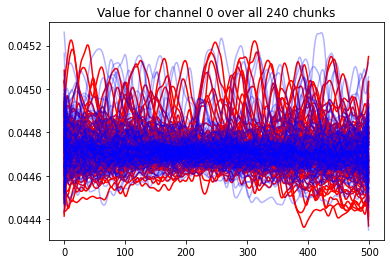

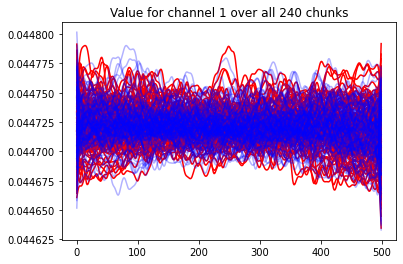

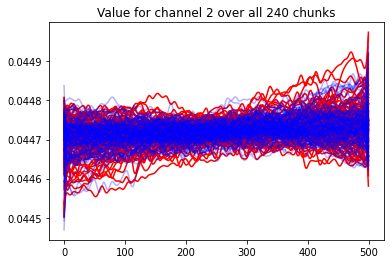

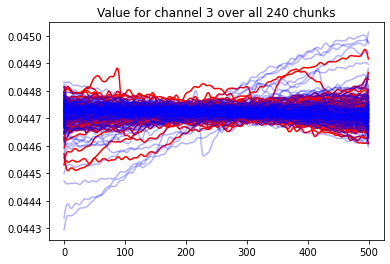

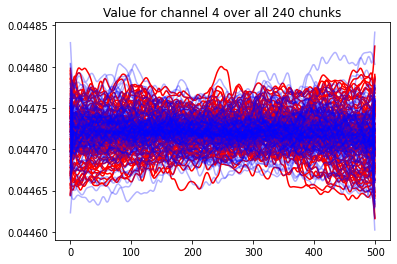

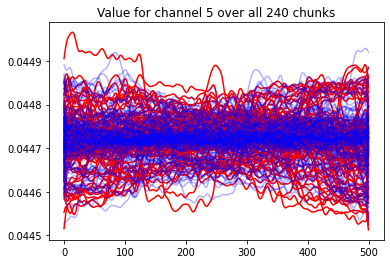

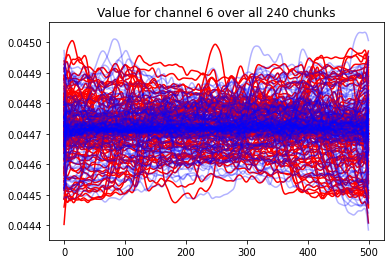

In [57]:
# Uncomment below if u wanna see a bunch of graphs of the data
print(pkldata.shape, pkllabels.shape)
print(pkllabels.shape)
x = pkldata[0]
only_no = [pkldata[i] for i in range(pkldata.shape[0]) if pkllabels[i][0] == 0]
only_no = np.array(only_no)
only_yes = [pkldata[i] for i in range(pkldata.shape[0]) if pkllabels[i][0] == 1]
only_yes = np.array(only_yes)
print(only_no.shape, only_yes.shape)
for i in range(pkldata.shape[1]):
    g = i + 1
    pyplot.plot(only_yes[0:, i, :].T, color="red")
    pyplot.plot(only_no[0:, i, :].T, alpha = .3, color="blue")
    pyplot.title("Value for channel {} over all {} chunks".format(i, pkldata.shape[0]))
    #pyplot.savefig(f"/content/drive/My Drive/Extra/processed_data_Riley_channel_{g}.png")
    pyplot.show()

# Building and training model

In [58]:
#hyperprameters
freq = 250
channels = 7
conv1_neurons = 25
conv2_neurons = 25
conv3_neurons = 50
conv4_neurons = 100
conv5_neurons = 200
learning_rate = 0.001
epochs = 120


In [59]:
#TODO: math for flattening
# kern1size = freq // 2
# convstride = 1

# padding_needed = (kern1size - 1) / 2
# conv1outx, conv1outy = (channels, (timepoints + (2 * padding_needed) - kern1size)/convstride + 1)

# print("1st layer output size:", conv1outx, conv1outy)

# conv2outx, conv2outy = ((conv1outx - channels)/convstride + 1, conv1outy)
# conv2outx, conv2outy = conv2outx // avg1stride[0], conv2outy // avg1stride[1]

# print("2nd layer output size:", conv2outx, conv2outy)

# conv3outx, conv3outy = (conv2outx, (conv2outy - kern3size)/convstride + 1)

# print("3rd layer output size:", conv3outx, conv3outy)

# conv4outx, conv4outy = (conv3outx, conv3outy)
# conv4outx, conv4outy = (conv4outx // avg2stride[0], conv4outy // avg2stride[1])

# print("4th layer output size:", conv4outx, conv4outy)

# flat1_in = int(conv4outx * conv4outy * conv4_neurons)

In [60]:
#TODO: might need to have a constrained conv2d's using a custom module
DeepNet = nn.Sequential(
    #reshape is being done in formatting 
    nn.Conv2d(1, conv1_neurons, (1, 5), bias=False),

    nn.Conv2d(conv1_neurons, conv2_neurons, (channels, 1), bias=False),
    nn.BatchNorm2d(conv2_neurons),
    nn.ELU(),
    nn.MaxPool2d((1,2)),
    nn.Dropout(),

    nn.Conv2d(conv2_neurons, conv3_neurons, (1,5), bias=False),
    nn.BatchNorm2d(conv3_neurons),
    nn.ELU(),
    nn.MaxPool2d((1,2)),
    nn.Dropout(),

    nn.Conv2d(conv3_neurons, conv4_neurons, (1,5), bias=False),
    nn.BatchNorm2d(conv4_neurons),
    nn.ELU(),
    nn.MaxPool2d((1,2)),
    nn.Dropout(),

    nn.Conv2d(conv4_neurons, conv5_neurons, (1,5), bias = False),
    nn.BatchNorm2d(conv5_neurons),
    nn.ELU(),
    nn.MaxPool2d((1,2)),
    nn.Dropout(),

    nn.Flatten(),
    nn.Linear(5400,1),
    nn.Sigmoid(),
)

DeepNet = DeepNet.to(device)

In [61]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(DeepNet.parameters(), learning_rate)

def test(model, device, test_loader):
  model.eval()
  correct = 0
  tot_loss = 0
  acc_score, prec_score, rec_score = 0, 0, 0

  with torch.no_grad():
    for (data, labels) in test_loader:
      data, labels = data.to(device), labels.to(device)

      classification = model(data.float())
      loss = loss_function(classification, labels)

      pred = torch.round(classification)
      correct += pred.eq(labels.view_as(pred)).sum().item()
      tot_loss += loss.item()

      acc_score += accuracy_score(labels, pred)
      prec_score += -precision_score(labels, pred)
      rec_score += recall_score(labels, pred)

    print("\nTest set: Total loss: {:.6f}, Accuracy: {:.6f}".format(tot_loss, 
                                                                          correct / len(test_loader.dataset)))
    # print(classification_report(labels, pred))
    return (tot_loss, acc_score, prec_score, rec_score)
  

In [62]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  correct = 0
  tot_loss = 0
  for batch, (data, labels) in enumerate(train_loader):
    data, labels = data.to(device), labels.to(device)

    optimizer.zero_grad()

    classification = model(data.float())
    loss = loss_function(classification, labels)

    loss.backward()
    optimizer.step()

    pred = torch.round(classification)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    tot_loss += loss.item()
  
  print("Epoch: {}".format(epoch))
  print("\tAverage loss: {:.6f}".format(tot_loss / (batch + 1)))
  print("\tAccuracy: {:.6f}".format(correct / len(train_loader.dataset)))

  labels_detached = labels.detach()
  preds_detached = pred.detach()
  print(classification_report(labels_detached, preds_detached))
  return (tot_loss / (batch + 1), correct / len(train_loader.dataset))

In [63]:
plots = {"train loss": [],
         "train acc": [],
         "test loss": [],
         "test acc": [],
         "test prec": [],
         "test rec": []}

for epoch in range(epochs):
  trl, tra = train(DeepNet, device, train_loader, optimizer, epoch)
  plots["train loss"].append(trl)
  plots["train acc"].append(tra)
  tl, ta, tp, tr = test(DeepNet, device, test_loader)
  plots["test loss"].append(tl)
  plots["test acc"].append(ta)
  plots["test prec"].append(tp)
  plots["test rec"].append(tr)

Epoch: 0
	Average loss: 0.838219
	Accuracy: 0.557292
              precision    recall  f1-score   support

         0.0       0.67      0.14      0.24        14
         1.0       0.59      0.94      0.72        18

    accuracy                           0.59        32
   macro avg       0.63      0.54      0.48        32
weighted avg       0.62      0.59      0.51        32


Test set: Total loss: 0.708445, Accuracy: 0.500000
Epoch: 1
	Average loss: 0.846598
	Accuracy: 0.552083
              precision    recall  f1-score   support

         0.0       0.54      0.94      0.68        16
         1.0       0.75      0.19      0.30        16

    accuracy                           0.56        32
   macro avg       0.64      0.56      0.49        32
weighted avg       0.64      0.56      0.49        32


Test set: Total loss: 0.695887, Accuracy: 0.500000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2
	Average loss: 0.768381
	Accuracy: 0.541667
              precision    recall  f1-score   support

         0.0       0.60      0.16      0.25        19
         1.0       0.41      0.85      0.55        13

    accuracy                           0.44        32
   macro avg       0.50      0.50      0.40        32
weighted avg       0.52      0.44      0.37        32


Test set: Total loss: 0.705096, Accuracy: 0.500000
Epoch: 3
	Average loss: 0.708323
	Accuracy: 0.546875
              precision    recall  f1-score   support

         0.0       0.53      0.56      0.54        18
         1.0       0.38      0.36      0.37        14

    accuracy                           0.47        32
   macro avg       0.46      0.46      0.46        32
weighted avg       0.46      0.47      0.47        32


Test set: Total loss: 0.772975, Accuracy: 0.500000
Epoch: 4
	Average loss: 0.699938
	Accuracy: 0.588542
              precision    recall  f1-score   support

         0.0       0.58     

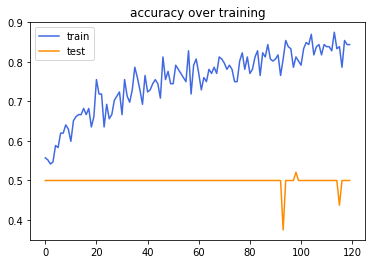

In [64]:
pyplot.plot(plots["train acc"], "royalblue", label = "train")
pyplot.plot(plots["test acc"], "darkorange", label = "test")
pyplot.title("accuracy over training")
pyplot.legend()
pyplot.show()

In [65]:
# tload = torch.utils.data.TensorDataset(X_train, X_actual)
# tloader = torch.utils.data.DataLoader(tload, batch_size = X_train.shape[0], shuffle = True)
# _, _, _, _ = test(DeepNet, device, tloader)
_, _, _, _ = test(DeepNet, device, test_loader)


Test set: Total loss: 50.000000, Accuracy: 0.500000
